# Introduction
This notebook will handle a denoising autoencoder on the MNIST-dataset.

The specifics of autoencoding are in the fact that there is no label needed to predict as it is known in common deep-learning architecture. Under this particular architecture, the goal is to "predict" its given input values (the features). Therefore we better say "reconstruct" instead of "predict". The model is forced to reconstruct the the given features, this is implemented through three major changes to the traditional NN structure:
1. Building the model out of two seperate models (encoder and decorder).
2. Reducing the given information in the middle of the network (codings).
3. Using the features as label values as well (prediction value is the input).

You will find these structures as well as two variations of denoising autoencoders in this notebook, one with a simple deep neural network (Deep Denoising Autoencoder) and a dropout layer and another one (Convolutional Denoising Autoencoder) with convolution layers and a GaussianNoise creation.

## My other Projects
If you are interested in some more clearly analysis of the dataset, take a look into my other notebooks about the MNIS-dataset:

- cnn-for-digit-recognition-MNIST (accuracy score: 0.99135):
    - https://www.kaggle.com/skiplik/cnn-for-digit-recognition-mnist 
- Finetuning Hyperparameters in Deep Neural Network:
    - https://www.kaggle.com/skiplik/finetuning-hyperparameters-in-deep-neural-network
- Digit Recognition with a Deep Neural Network:
    - https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try:
    - https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters:
    - https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters 
- ...

# Imports

In [976]:
import sys
assert sys.version_info >= (3,5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers

#import mlflow
#from mlflow import log_metric, log_param, log_artifacts
#import mlflow.tensorflow
#from mlflow import pyfunc

assert tf.__version__ >= "2.0"

print(f"Tensorflow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")


tf.random.set_seed(42)
np.random.seed(42)
random_state=42

kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../autoencoding-mnist/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version: 2.7.0
Keras Version: 2.7.0
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
../autoencoding-mnist/data/input/digit-recognizer\test.csv
../autoencoding-mnist/data/input/digit-recognizer\train.csv


## Get The Data

In [977]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_csv_data(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path)

def load_csv_data_manuel(path, csv_file):
    csv_path = os.path.join(path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data
    

train = load_csv_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_csv_data(MNIST_PATH,CSV_FILE_TEST)

### Train Val Split

In [978]:
X_train, X_valid, y_train, y_valid =  train_test_split(train.loc[:, train.columns != 'label'], train['label'], test_size=0.33, random_state=random_state)

### Preparing for Neural Network Structure

In [979]:
X_train = X_train.astype(np.float32) / 255
X_valid = X_valid.astype(np.float32) / 255
X_test = test.astype(np.float32) / 255

In [980]:
print(f"'X_train' shape: {X_train.shape}")
print(f"'X_valid' shape: {X_valid.shape}")
print(f"'X_test' shape: {X_test.shape}")

'X_train' shape: (28140, 784)
'X_valid' shape: (13860, 784)
'X_test' shape: (28000, 784)


#### Reshaping Data in Tensor Batch Structure

In [981]:
### DEBUG TODO: implement /wo chanel param
def reshape_images(df_images):
    '''Reshaping image structure to a three dimensional tensor'''
    df_images_resh = df_images.values.reshape(df_images.shape[0], 28, 28)
    return df_images_resh

def reshape_conv_images(df_images):
    '''
    Reshaping image structure to a four dimensional tensor for conv networks,
    where chanel is last
    '''
    df_images_conv_resh = df_images.values.reshape(df_images.shape[0], 28, 28, 1)
    return df_images_conv_resh

In [982]:
X_train_resh = reshape_images(X_train)
X_valid_resh = reshape_images(X_valid)
X_test_resh = reshape_images(X_test)

y_train_resh =  y_train.values.reshape(y_train.shape[0], 1)
y_valid_resh = y_valid.values.reshape(y_valid.shape[0], 1)

In [983]:
print(f"'X_train_resh' shape: {X_train_resh.shape}")
print(f"'X_valid_resh' shape: {X_valid_resh.shape}")
print(f"'X_test_resh' shape: {X_test_resh.shape}")
print(f"'y_train_resh' shape: {y_train_resh.shape}")
print(f"'y_valid_resh' shape: {y_valid_resh.shape}")

'X_train_resh' shape: (28140, 28, 28)
'X_valid_resh' shape: (13860, 28, 28)
'X_test_resh' shape: (28000, 28, 28)
'y_train_resh' shape: (28140, 1)
'y_valid_resh' shape: (13860, 1)


# Plotting 

In [984]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, X_valid, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

### Plotting One Example Value

In [985]:
print(f"Example label: {y_valid.iloc[1]}")

Example label: 1


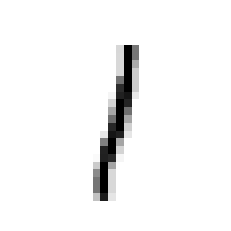

In [986]:
plot_image(X_valid.iloc[1].values.reshape(28,28))

# First Model - Deep Denoising Autoencoder 
An autoencoder architecture includes two seperate models, the encoder and the decorder. In the neuron point of view they both have a rejuvenation which represents a need of information compression - keep only the realy relevant information and drop the less relevant information. The encoder has an input of 784 neurons and an output of only 30 (which represents the codings). On the otherside the decoder has an inputshape of 30 neurons with an layer of 100 neurons, which rises to an layer of 28 * 28 neurons (=784) again. 

These two models combined bring the need of reducing given information and (artificially) recreating them again. Thats the specialty of the autoencoder structure.

### Encoder Architecture

In [987]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")           # Codings
])

In [988]:
dropout_encoder.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 dropout_9 (Dropout)         (None, 784)               0         
                                                                 
 dense_61 (Dense)            (None, 100)               78500     
                                                                 
 dense_62 (Dense)            (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


#### Decoder Architecture

In [989]:
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),  ### PROBLEM AREA found: USE THE RIGHT ACTIVATION FUNCTION
    keras.layers.Reshape([28, 28])
])

In [990]:
dropout_decoder.summary()

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 100)               3100      
                                                                 
 dense_64 (Dense)            (None, 784)               79184     
                                                                 
 reshape_18 (Reshape)        (None, 28, 28)            0         
                                                                 
Total params: 82,284
Trainable params: 82,284
Non-trainable params: 0
_________________________________________________________________


### Building the Model

In [991]:
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

c:\Python Workspace\Schadenprognose\.venv\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


## Training and Logging -  Deep Denoising Autoencoder

### Logging the Model (ML Flow)

In [992]:
#mlflow.tensorflow.autolog()

### Training the Model

In [993]:
history = dropout_ae.fit(X_train_resh, X_train_resh, epochs= 10, validation_data=(X_valid_resh, X_valid_resh))


Epoch 1/10
880/880 [==============================] - 5s 5ms/step - loss: 0.2242 - val_loss: 0.1742
Epoch 2/10
880/880 [==============================] - 4s 5ms/step - loss: 0.1679 - val_loss: 0.1491
Epoch 3/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1543 - val_loss: 0.1407
Epoch 4/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1480 - val_loss: 0.1339
Epoch 5/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1436 - val_loss: 0.1311
Epoch 6/10
880/880 [==============================] - 5s 6ms/step - loss: 0.1406 - val_loss: 0.1310
Epoch 7/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1378 - val_loss: 0.1277
Epoch 8/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1356 - val_loss: 0.1261
Epoch 9/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1337 - val_loss: 0.1222
Epoch 10/10
880/880 [==============================] - 5s 5ms/step - loss: 0.1321 - val_loss: 0.1204

### Losses
The question is: "How good does the model reconstruct the given features/information". So there is no prediction of some label value! The model "predicts" (or better) reconstruct its input values to its best

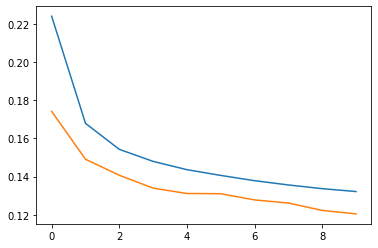

In [994]:
# Getting in touch with the model statistics 
# shows the available keys in models history:  print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Second Model - Convolutional Denoising Autoencoder 

### Convolutional Encoder Architecture  

In [995]:
conv_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape = [28, 28, 1]),
    keras.layers.Conv2D(16, kernel_size=3, activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
    keras.layers.MaxPool2D(pool_size=4),
    keras.layers.Dense(392, activation="relu")           # Codings
])

In [996]:
conv_encoder.summary()

Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_9 (GaussianN  (None, 28, 28, 1)        0         
 oise)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                     

### Convolutional Decoder Architecture

In [997]:
conv_decoder = keras.models.Sequential([
    #keras.layers.GaussianNoise(0.1, input_shape=[6, 6, 32] ),
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid",activation="selu", input_shape=[3, 3, 392]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same",activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    keras.layers.Reshape([28, 28, 1])
])

In [998]:
conv_decoder.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_27 (Conv2D  (None, 7, 7, 32)         112928    
 Transpose)                                                      
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 14, 14, 16)       4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 28, 28, 1)        145       
 Transpose)                                                      
                                                                 
 reshape_19 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
Total params: 117,697
Trainable params: 117,697
Non-trainable params: 0
_______________________________________________

### Building the Model - Deep Convolutional Denoising Autoencoder

In [999]:
conv_denoising_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))

In [1000]:
conv_denoising_ae.summary()

Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_73 (Sequential)  (None, 3, 3, 392)         17736     
                                                                 
 sequential_74 (Sequential)  (None, 28, 28, 1)         117697    
                                                                 
Total params: 135,433
Trainable params: 135,433
Non-trainable params: 0
_________________________________________________________________


## Training and Logging - Deep Convolutional Denoising Autoencoder

### Training the Model

In [1001]:
X_train_resh_ch = reshape_conv_images(X_train)
X_valid_resh_ch = reshape_conv_images(X_valid)
X_test_resh_ch = reshape_conv_images(X_test)

## DEBUG TODO: Clean this up after test
#X_train_resh_ch = X_train_resh.reshape(X_train_resh.shape[0], 28 ,28 ,1)
#X_valid_resh_ch = X_valid_resh.reshape(X_valid_resh.shape[0], 28 ,28 ,1)

In [1002]:
history = conv_denoising_ae.fit(X_train_resh_ch, X_train_resh_ch, epochs= 10, validation_data=(X_valid_resh_ch, X_valid_resh_ch))


Epoch 1/10
880/880 [==============================] - 22s 24ms/step - loss: 0.1775 - val_loss: 0.1157
Epoch 2/10
880/880 [==============================] - 23s 26ms/step - loss: 0.1079 - val_loss: 0.1033
Epoch 3/10
880/880 [==============================] - 22s 24ms/step - loss: 0.0982 - val_loss: 0.0957
Epoch 4/10
880/880 [==============================] - 21s 24ms/step - loss: 0.0938 - val_loss: 0.0917
Epoch 5/10
880/880 [==============================] - 20s 23ms/step - loss: 0.0910 - val_loss: 0.0882
Epoch 6/10
880/880 [==============================] - 20s 22ms/step - loss: 0.0891 - val_loss: 0.0890
Epoch 7/10
880/880 [==============================] - 20s 22ms/step - loss: 0.0876 - val_loss: 0.0912
Epoch 8/10
880/880 [==============================] - 20s 22ms/step - loss: 0.0865 - val_loss: 0.0855
Epoch 9/10
880/880 [==============================] - 20s 22ms/step - loss: 0.0856 - val_loss: 0.0841
Epoch 10/10
880/880 [==============================] - 20s 23ms/step - loss: 0.084

In [1003]:
# saving model for weight using in later process
conv_denoising_ae.save('conv_denoising_ae')

INFO:tensorflow:Assets written to: conv_denoising_ae\assets


In [1004]:
# Probably not working on Kaggle
#plot_model(conv_denoising_ae, 'conv_autencoder.png', show_shapes=True)

# Results - Deep Denoising Autoencoder

## Real Image

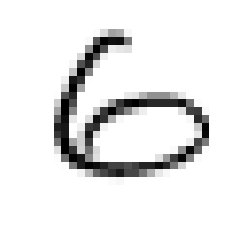

In [1005]:
# Test image from a known set
plot_image(X_valid_resh[10])

## ("Predicted") Reconstructed One

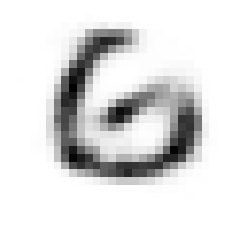

In [1006]:
testimage = X_valid_resh[10].reshape(1, 28, 28)     # single image prepared for the test (reshape)
plot_image(dropout_ae.predict(testimage)[0, :, :])  # needed to extract the second and third array of the three dimensional tensor struc for printing the image

## Showing Multi Results

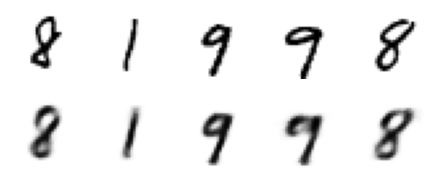

In [1007]:
show_reconstructions(dropout_ae, X_valid_resh)

## Using Noised Images

### Creating Noisy Data


In [1008]:
new_images = X_test[5:10]
new_images = reshape_images(new_images)
noisy_images = new_images + np.random.randn(5,28,28) *0.1

### Origin Number


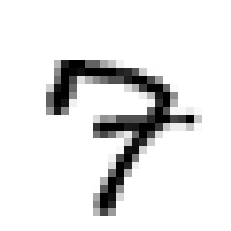

In [1009]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images[idx_testnumber])

### Noisy Number

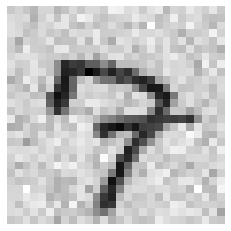

In [1010]:
plot_image(noisy_images[idx_testnumber])

### Denoised Number

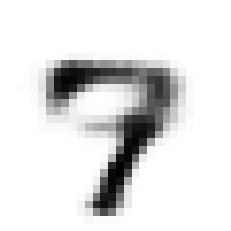

In [1011]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(dropout_ae.predict(noisy_images[np.newaxis ,idx_testnumber]).reshape(28,28)) 

### Multiple Numbers in Comparision 

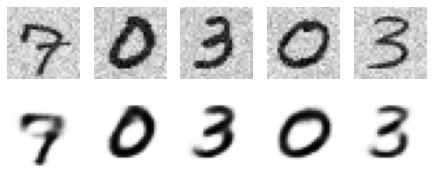

In [1012]:
show_reconstructions(dropout_ae, noisy_images)

# Results - Convolutional Denoising Autoencoder

## Using Noised Images

### Creating Noisy Data

In [1013]:
new_images_conv = X_test[5:10]
new_images_conv = reshape_conv_images(new_images_conv)
noisy_images_conv = new_images_conv + np.random.randn(5, 28, 28, 1) *0.1

In [1014]:
noisy_images_conv.shape

(5, 28, 28, 1)

### Origin Number


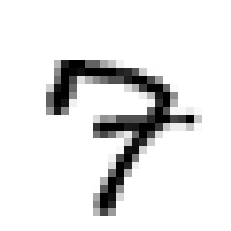

In [1015]:
idx_testnumber = 0      # Index of test number for the next plottings 
plot_image(new_images_conv[idx_testnumber])

### Noisy Number

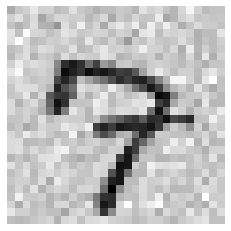

In [1016]:
plot_image(noisy_images_conv[idx_testnumber])

### Denoised Number

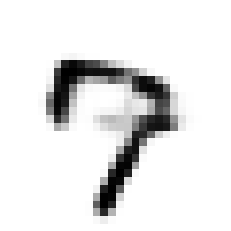

In [1017]:
# Very Important ! added a new axis according to the models batch based behavior
plot_image(conv_denoising_ae.predict(noisy_images_conv[np.newaxis ,idx_testnumber]).reshape(28,28))

### Multiple Numbers in Comparision

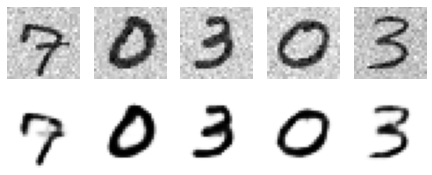

In [1018]:
show_reconstructions(conv_denoising_ae, noisy_images_conv)

# Unsupervised Pre-Training for Supervised Training
In this part I will use the first layers of the already trained autoencoder for implementing a classification prediction model. This architecture represents the way of using unsupervised pre-training for projects that do not have enough training data to train the final model (in this case the classification model).

In [1053]:
# Loading untouched model weights 
# Doing this for the reason that model weights are modified not only for a specific created model object (thats what I was recognizing), but for the stored object in the cache.
# Therefore I load here the model new from storage to be capable of running multiple new model trainings without any influence on previous runs (make this trainig deterministic)
conv_denoising_ae_clone = tf.keras.models.load_model("conv_denoising_ae")

In [1021]:
ae_model_id = 0 # 0 for encorder / 1 for decorder
layerscount = 5 # how many layers of the model ...


new_model = keras.models.Sequential(conv_denoising_ae_clone.layers[ae_model_id].layers[:layerscount])
new_model.trainable =True  # Setting it on True to sepcificly set them on False afterwards  

In [1023]:
new_model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_9 (GaussianN  (None, 28, 28, 1)        0         
 oise)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                     

### Making the Layers Trainable / Not-Trainable
The already trained layers which has been trained on the unsupervised way above, needs to be frozen so that only the new layers for the new topic (classification) can be trained.


In [1024]:
# Make the layers not trainable 
for layer in new_model.layers[:layerscount -1 ]:              # last layer still be trainable
    layer.trainable = False
    print(f"Layer '{layer.name}' is Trainable = {layer.trainable}")

Layer 'gaussian_noise_9' is Trainable = False
Layer 'conv2d_18' is Trainable = False
Layer 'max_pooling2d_18' is Trainable = False
Layer 'conv2d_19' is Trainable = False


In [1025]:
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dense(10, activation="softmax"))

In [1026]:
# Viewing final layers-construction and its trainabilaties
for layer in new_model.layers:
    print(f"Layer '{layer.name}' trainable state = {layer.trainable}")

Layer 'gaussian_noise_9' trainable state = False
Layer 'conv2d_18' trainable state = False
Layer 'max_pooling2d_18' trainable state = False
Layer 'conv2d_19' trainable state = False
Layer 'max_pooling2d_19' trainable state = True
Layer 'flatten_26' trainable state = True
Layer 'dense_66' trainable state = True


In [1027]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Nadam(), metrics=["accuracy"]) ##keras.optimizers.SGD(learning_rate=0.0003)

In [1028]:
new_model.summary()

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_9 (GaussianN  (None, 28, 28, 1)        0         
 oise)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 3, 3, 32)         0         
 g2D)                                                            
                                                     

In [1029]:
#from tensorflow.keras.utils import plot_model

#plot_model(new_model, 'autencoder_base_w_classifier.png', show_shapes=True)

In [1030]:
# DEBUG
trainlayer_id = 3

new_model.get_layer(index=trainlayer_id).trainable

False

In [1031]:
new_model.get_layer(index=trainlayer_id).weights

[<tf.Variable 'conv2d_19/kernel:0' shape=(3, 3, 16, 32) dtype=float32, numpy=
 array([[[[ 8.76781717e-02, -1.11983880e-01, -3.15263607e-02, ...,
           -9.55396816e-02, -1.36937901e-01, -4.35677581e-02],
          [ 6.03629909e-02,  4.78179529e-02, -4.82308475e-04, ...,
            1.20118298e-01, -2.31758561e-02, -4.36157323e-02],
          [-9.18869078e-02,  1.25629932e-01,  3.81286955e-04, ...,
           -3.89694646e-02, -3.33507285e-02,  7.97315985e-02],
          ...,
          [ 7.81575143e-02, -5.97815737e-02, -5.81670413e-03, ...,
            4.01943438e-02, -1.24625951e-01,  1.30590489e-02],
          [-3.95538472e-03,  5.75804561e-02, -1.05435595e-01, ...,
           -6.02366067e-02,  1.98270082e-02,  8.11425969e-02],
          [-2.49206368e-02,  1.97702572e-01,  4.93478915e-03, ...,
            1.16087906e-01,  3.33083451e-01, -8.51361454e-02]],
 
         [[ 1.26040980e-01, -1.39396176e-01,  4.82106954e-02, ...,
            9.12470296e-02, -3.40500474e-01,  9.46780816e

In [1032]:
# DEBUG: to Delete
conv_denoising_ae_clone.layers[0].get_layer(index=trainlayer_id).weights

[<tf.Variable 'conv2d_19/kernel:0' shape=(3, 3, 16, 32) dtype=float32, numpy=
 array([[[[ 8.76781717e-02, -1.11983880e-01, -3.15263607e-02, ...,
           -9.55396816e-02, -1.36937901e-01, -4.35677581e-02],
          [ 6.03629909e-02,  4.78179529e-02, -4.82308475e-04, ...,
            1.20118298e-01, -2.31758561e-02, -4.36157323e-02],
          [-9.18869078e-02,  1.25629932e-01,  3.81286955e-04, ...,
           -3.89694646e-02, -3.33507285e-02,  7.97315985e-02],
          ...,
          [ 7.81575143e-02, -5.97815737e-02, -5.81670413e-03, ...,
            4.01943438e-02, -1.24625951e-01,  1.30590489e-02],
          [-3.95538472e-03,  5.75804561e-02, -1.05435595e-01, ...,
           -6.02366067e-02,  1.98270082e-02,  8.11425969e-02],
          [-2.49206368e-02,  1.97702572e-01,  4.93478915e-03, ...,
            1.16087906e-01,  3.33083451e-01, -8.51361454e-02]],
 
         [[ 1.26040980e-01, -1.39396176e-01,  4.82106954e-02, ...,
            9.12470296e-02, -3.40500474e-01,  9.46780816e

In [1033]:
new_model.save('class_net_01')

INFO:tensorflow:Assets written to: class_net_01\assets


## Creating Training Data for Unsupervised Pre-Training Model
In this part 500 datarow sets will be created for training a normal backpropagation model based on the unsupervised pre-trained model.

Additionally the remaining datarows will be used for testing the models accuracy.

In [1034]:
X_train_resh_ch[:500].shape


(500, 28, 28, 1)

In [1035]:
X_valid_resh_ch[500:].shape

(13360, 28, 28, 1)

In [1036]:
#DEBUG TODO: Using the reshape_conv_image function here or better the already converted dataframe set.

X_train_pret_resh_500 = X_train_resh_ch[:500]
X_valid_pret_resh_500 = X_valid_resh_ch[:500]

X_valid_pret_resh_r = X_valid_resh_ch[500:]   # Choosing the last 500 digits for testing unknown, untrained data

#X_train_pretrained_500 = X_train_resh[:500]
#X_valid_pretrained_500 = X_valid_resh[:500]

y_train_pretrained_500 = y_train_resh[:500]
y_valid_pretrained_500 = y_valid_resh[:500]

y_valid_pretrained_r = y_valid_resh[500:]


# reshaping for conv model structure (batchsize, pixel h, pixel w, channel)
#X_train_pret_resh_500 = X_train_pretrained_500.reshape(X_train_pretrained_500.shape[0],X_train_pretrained_500.shape[1], X_train_pretrained_500.shape[2], 1)
#X_valid_pret_resh_500 = X_valid_pretrained_500.reshape(X_valid_pretrained_500.shape[0],X_valid_pretrained_500.shape[1], X_valid_pretrained_500.shape[2], 1)



In [1037]:
print(X_train_pret_resh_500.shape)
print(X_valid_pret_resh_500.shape)
print(X_valid_pret_resh_l_500.shape)
print(y_train_pretrained_500.shape)
print(y_valid_pretrained_500.shape)
print(y_valid_pretrained_l_500.shape)



(500, 28, 28, 1)
(500, 28, 28, 1)
(500, 28, 28, 1)
(500, 1)
(500, 1)
(500, 1)


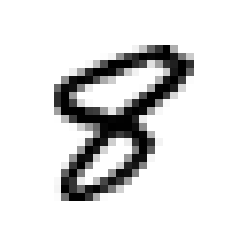

In [1038]:
plot_image(X_train_pret_resh_500[499])

In [1039]:
root_logdir = "../../tensorboard-logs"

def get_run_logdir(root_logdir, project):
    '''
    Returns logdir to the Tensorboard log for a specific project.

            Parameters:
                    root_logdir (str) : basic logdir from Tensorboard
                    project (str): projectname that will be logged in TB

            Returns:
                    os.path (str): Path to the final logdir
    '''
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    project_logdir = os.path.join(root_logdir,project)
    return os.path.join(project_logdir, run_id)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=get_run_logdir(root_logdir,"autoencoding_mnist"), histogram_freq=1)


In [1040]:
history_pretrainted = new_model.fit(X_train_pret_resh_500,y_train_pretrained_500 ,epochs=20, \
                                        validation_data=(X_valid_pret_resh_500,y_valid_pretrained_500), \
                                        callbacks=tensorboard_callback
                                    )


Epoch 1/10
16/16 [==============================] - 1s 22ms/step - loss: 4.1167 - accuracy: 0.1120 - val_loss: 2.7740 - val_accuracy: 0.1120
Epoch 2/10
16/16 [==============================] - 0s 13ms/step - loss: 2.3786 - accuracy: 0.0820 - val_loss: 1.8822 - val_accuracy: 0.1040
Epoch 3/10
16/16 [==============================] - 0s 12ms/step - loss: 1.6203 - accuracy: 0.0780 - val_loss: 1.3303 - val_accuracy: 0.1440
Epoch 4/10
16/16 [==============================] - 0s 12ms/step - loss: 1.2221 - accuracy: 0.0860 - val_loss: 1.0017 - val_accuracy: 0.1080
Epoch 5/10
16/16 [==============================] - 0s 12ms/step - loss: 0.9190 - accuracy: 0.0700 - val_loss: 0.8222 - val_accuracy: 0.1260
Epoch 6/10
16/16 [==============================] - 0s 11ms/step - loss: 0.7353 - accuracy: 0.0800 - val_loss: 0.7186 - val_accuracy: 0.1160
Epoch 7/10
16/16 [==============================] - 0s 12ms/step - loss: 0.6241 - accuracy: 0.0740 - val_loss: 0.6219 - val_accuracy: 0.1100
Epoch 8/10
16

### Loss Plotting

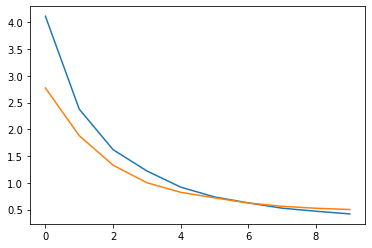

In [1041]:
plt.plot(history_pretrainted.history['loss'])
plt.plot(history_pretrainted.history['val_loss'])

## Predicting the Digits on a Pre-Trained Autoencoder based Model

The prediction test on unseen data with the pre-trained autoencoder based model will be used with the validation dataset. The model is trained on the first 500 digits from the train set and validated by the first 500 digits on the validation set. There are still enough data in the validation set (and in the train dataset but it sounds better to use the validation set for) to test the model with unseen data (in total 13.360 digits).

First there is a visualized test, where the test digit and its prediction will be printed.

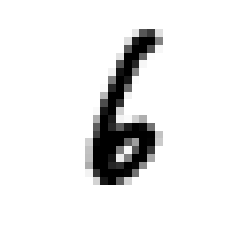

In [1050]:
idx_testnumber_cls_ae = 8      # Index of test number for the next plottings 
plot_image(X_valid_pret_resh_r[idx_testnumber_cls_ae])

In [1052]:
print(f"Prediction based on the picture above: {np.argmax(new_model.predict(X_valid_pret_resh_r[np.newaxis, idx_testnumber_cls_ae]))}")
print(f"Probability of the Prediction: {new_model.predict(X_valid_pret_resh_r[np.newaxis, idx_testnumber_cls_ae])}")


Prediction based on the picture above: 6
Probability of the Prediction: [[0.00128029 0.41287717 0.00164264 0.00607237 0.075052   0.00086092
  0.4848449  0.00169149 0.00999648 0.00568178]]


Following will be determine the accuracy on the remaining validation dataset of 13.360 digits and shows the overall accuracy of the model after pre-training and classification training.

In [1046]:
y_val_pred_r = new_model.predict(X_valid_pret_resh_r)
y_val_pred_r = y_val_pred_r.argmax(axis = 1)[:,None]

In [1047]:
from sklearn.metrics import accuracy_score
acc_score_val = accuracy_score(y_valid_pretrained_r, y_val_pred_r)

print(f"Unsupervised pre-trained model, trained on 500 digits, predicting {y_val_pred_r.shape[0]:} digit with only 20 epochs trained with an accuracy of: {acc_score_val}")

Unsupervised pre-trained model, trained on 500 digits, predicting 13360 digit with only 10 epochs with an accuracy of: 0.827619760479042
